### Large-Scale Data Mining: Models and Algorithms (ECE 219 Winter 2019) Prof. Vwani Roychowdhury 
------
# Project 3: Collaborative Filtering
Xiongfeng Zhu, 404436256

Pei-Shan Chung, 004685318

#### Note
The readme file in MovieLens mentions that there are 9742 movies and 610 users.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import csv file as np array with default loading data type of float
ratings = pd.read_csv('ml-latest-small/ratings.csv')
print(ratings.head(5))
print('Total number of available ratings: ', ratings.shape[0])

total = 9742*610
print('Total number of possible ratings: ',total)

sparsity=ratings.shape[0]/total
print('Sparsity is {:.4f}'.format(sparsity))

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
Total number of available ratings:  100836
Total number of possible ratings:  5942620
Sparsity is 0.0170


## Question 2
Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram


Text(0.5, 1.0, 'rating histogram')

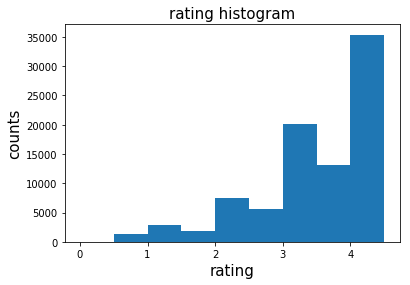

In [27]:
hist=ratings.hist(column='rating',bins=np.arange(0,5,0.5),grid=False)
plt.xlabel('rating',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.title('rating histogram',fontsize=15)

#### Ans
From the plot we find the rating histogram is skewed. Most of the rated movies tend to have a higher score, while low ratings are less. That means people are more likely to rate a movie when they like it and as a result will rate the movie with a high score. People are less likely to leave a low rating score after seeing a 'bad' movie, maybe because they feel they already wasted time watching it and don't bother to leave a rating.

Also people tend to rate integer scores (1, 2, 3,...) rather than fractional scores (1.5, 2.5,...). Both zero score and full score are rare.

## Question 3
Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by decreasing frequency and the Y-axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

Text(0.5, 1.0, 'movie rating frequency plot')

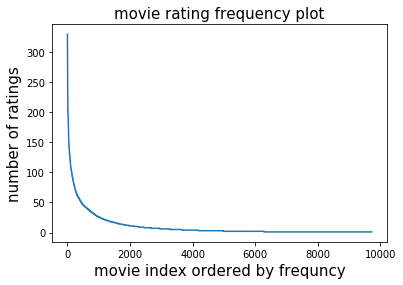

In [28]:
frequency=ratings.groupby('movieId').count().sort_values(by='rating',ascending=False)
plt.plot(frequency['rating'].values)
plt.xlabel('movie index ordered by frequncy',fontsize=15)
plt.ylabel('number of ratings',fontsize=15)
plt.title('movie rating frequency plot',fontsize=15)

#### Ans
A monotonically decreasing curve is obtained. Only a small amount of movies have more than 50 ratings. Rest of them have just a few ratings. 


## Question 4
Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3. 

Text(0.5, 1.0, 'user rating frequency plot')

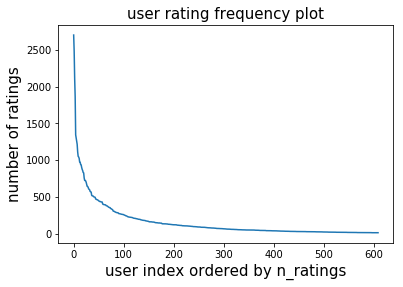

In [29]:
n_ratings=ratings.groupby('userId').count().sort_values(by='rating',ascending=False)
plt.plot(n_ratings['rating'].values)
plt.xlabel('user index ordered by n_ratings',fontsize=15)
plt.ylabel('number of ratings',fontsize=15)
plt.title('user rating frequency plot',fontsize=15)

#### Ans
A monotonically decreasing curve is obtained. Only a small amount of users have rated more than 500 movies. Rest of them have rated at least 20 movies or more.

## Question 5
Explain the salient features of the distribution found in question 3 and their implications for the recommendation process. 

#### Ans
Very few movies received enough ratings. Most movies have lots of unspecified ratings from users and the rating matrix will be sparse. It's necassary to fill in those unspecified ratings by prediction using collaborative filtering.

## Question 6
Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram 

Text(0.5, 1.0, 'movie rating variance histogram')

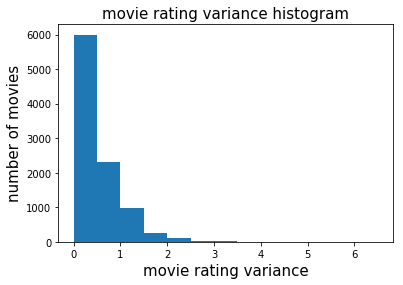

In [30]:
rating_variance=ratings.groupby('movieId').var(ddof=0)['rating']
rating_variance.hist(grid=False,bins=np.arange(0,7,0.5))
plt.xlabel('movie rating variance',fontsize=15)
plt.ylabel('number of movies',fontsize=15)
plt.title('movie rating variance histogram',fontsize=15)

The plot is skewed to the left, most movies receive ratings with a low variance. That means most of them have consistent feedback from views and few movies have controversial or debatable ratings among viewers.

## Question 7
### Pearson-correlation coefficient

Pearson-correlation coefficient between users u and v, denoted by Pearson(u,v), captures the similarity between the rating vectors of users u and v. Before stat- ing the formula for computing Pearson(u,v), let’s first introduce some notation:
* Iu : Set of item indices for which ratings have been specified by user u 
* Iv : Set of item indices for which ratings have been specified by user v 
* μu: Mean rating for user u computed using her specified ratings
* ruk: Rating of user u for item k

Write down the formula for μu in terms of Iu and ruk 


#### Ans 
$μ_u=mean(\sum_{k\in I_u}r_{uk})$

## Question 8
In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅
(Hint: Rating matrix R is sparse). 

#### Ans
Iu ∩ Iv means the set of movies that receive ratings from both user u and user v. It's possible that Iu ∩ Iv = ∅ since the rating matrix is so sparse. Some users can have no common-rated movie at all.

## Question 9
Can you explain the reason behind mean-centering the raw ratings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function) 

#### Ans
After mean-centering, what's left in the ratings is one user's preference variance across different movies. We can capture some similarity between two users according to their preference across movies. A person rating all movies with high scores has high correlation with a person rating all movies with low scores. In some way, it's providing similarity information for different movies.

## Question 10
Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

* Surprise https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [10]:
# define folds, trim test folds, save csv files
import os
from sklearn.model_selection import KFold
def define_folds(ratings,trim=None):
    popular_movies = ratings.groupby('movieId').filter(lambda x: x['rating'].count()>2)['movieId'].unique()
    unpopular_movies = ratings.groupby('movieId').filter(lambda x: x['rating'].count()<=2)['movieId'].unique()
    high_var_movies=ratings.groupby('movieId').filter(lambda x: (x['rating'].count()>=5) 
                                                      & (x['rating'].var(ddof=0)>=2))['movieId'].unique()
    if not trim: trim='no_trim' 
    if not os.path.isdir(trim): os.makedirs(trim) 
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    folds_files=[]
    for i,(train_index, test_index) in enumerate(kf.split(ratings)):
        #X_train, X_test = ratings.iloc[train_index], ratings.iloc[test_index]
        #if trim=='popular': X_test=X_test[X_test['movieId'].isin(popular_movies)]
        #elif trim=='unpopular': X_test=X_test[X_test['movieId'].isin(unpopular_movies)]
        #elif trim=='high_var': X_test=X_test[X_test['movieId'].isin(high_var_movies)]
        train_file,test_file=trim+'/trainset_{:}.csv'.format(i),trim+'/testset_{:}.csv'.format(i)
        #X_train.to_csv(train_file,header=False,index=False)
        #X_test.to_csv(test_file,header=False,index=False)
        folds_files.append((train_file,test_file))
    return folds_files

In [8]:
from surprise import Dataset
from surprise import Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import PredefinedKFold
from surprise import accuracy

"""
def design_KNN(ratings):
    # A reader is still needed but only the rating_scale param is requiered.
    reader = Reader(rating_scale=(0.5, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    k_list=np.arange(2,100,2)
    param_grid = {'k': k_list,
                  'sim_options': {'name': ['pearson'],
                                  'user_based': [True]}
                  }
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=10, n_jobs=-1)
    gs.fit(data)

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))
    ax1.plot(k_list,gs.cv_results['mean_test_rmse'])
    ax1.set_title('mean rmse')
    ax1.set_xlabel('number of neighbors k')
    ax2.plot(k_list,gs.cv_results['mean_test_mae'])
    ax2.set_title('mean mae')
    ax2.set_xlabel('number of neighbors k')
    return gs.cv_results
"""
# df -> dataset (cv,fold...) -> trainset (fit) -> testset (test)
def algo_cv(model,ratings,k_list,trim=None,**kwargs):
    reader = Reader(line_format='user item rating timestamp', sep=',',rating_scale=(0.5, 5))
    folds_files=define_folds(ratings,trim)
    data = Dataset.load_from_folds(folds_files, reader)
    pkf = PredefinedKFold()
    mean_RMSE = []
    mean_MAE =[]
    for k in k_list:
        #print('k (number of neighbors) = {}'.format(i))
        algo = model(k, **kwargs)
        ret = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=pkf, verbose=False, n_jobs=-1)
        mean_RMSE.append(np.mean(ret['test_rmse']))
        mean_MAE.append(np.mean(ret['test_mae'])) 

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))
    ax1.plot(k_list,mean_RMSE,label='mean rmse')
    ax1.set_xlabel('number of neighbors k')
    ax1.legend()
    ax2.plot(k_list,mean_MAE,label='mean mae')
    ax2.set_xlabel('number of neighbors k')
    ax2.legend()
    if trim:
        plt.suptitle('trimmed testset on '+trim+', minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    else:
        plt.suptitle('No trim on testset on, minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    return mean_RMSE, mean_MAE    

### Q10, 12-14

CPU times: user 1h 5min 18s, sys: 56.7 s, total: 1h 6min 15s
Wall time: 1h 10min 18s


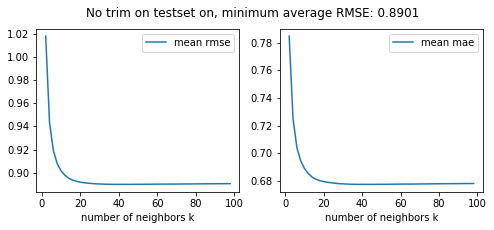

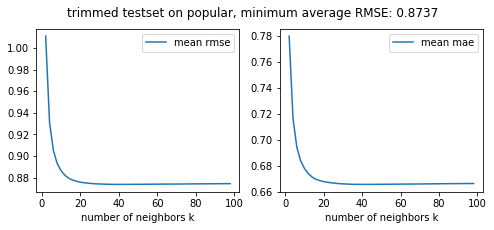

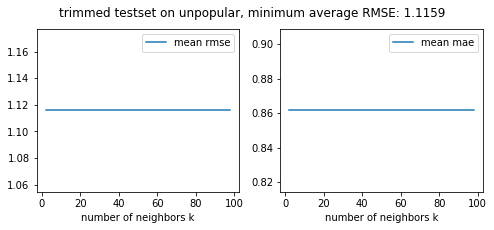

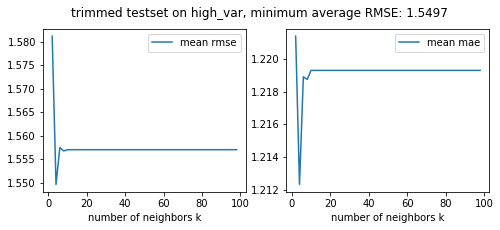

In [33]:
%%time
model=KNNWithMeans
k_list=list(range(2,100,2))
rmse,mae=algo_cv(model,ratings,k_list,trim=None,sim_options={'name': 'pearson','user_based': True},verbose=False)
rmse_pop,mae_pop=algo_cv(model,ratings,k_list,trim='popular',sim_options={'name': 'pearson','user_based': True},verbose=False)
rmse_unpop,mae_unpop=algo_cv(model,ratings,k_list,trim='unpopular',sim_options={'name': 'pearson','user_based': True},verbose=False)
rmse_high_var,mae_hig_var=algo_cv(model,ratings,k_list,trim='high_var',sim_options={'name': 'pearson','user_based': True},verbose=False)

## Question 11
Use the plot from question 10, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE

#### Ans
The RMSE and MAE converge to steady-state values, the ‘minimum k’ can be set to 30, beyond which no significant decrease in the metrics can be gained.

## Question 15
Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

In [4]:
from surprise.model_selection import train_test_split
from sklearn import metrics

def plot_roc_curve(algo,ratings,label):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    scores=[pred.est for pred in predictions]
    rui_list=[pred.r_ui for pred in predictions]
    thresholds=[2.5, 3, 3.5, 4]
    for t in thresholds:
        y=[int(rui>t) for rui in rui_list]
        fpr, tpr, _= metrics.roc_curve(y, scores, pos_label=1)
        auc=metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,label=label+', threshold={:}, area={:.4f}'.format(t,auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

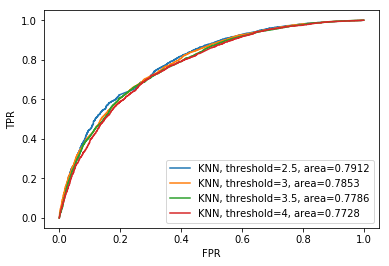

In [34]:
algo = KNNWithMeans(k=30, sim_options={'name': 'pearson','user_based': True},verbose=False)
plot_roc_curve(algo,ratings,'KNN')

### Question 16: 
Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

It's not convex, because the Hessian matrix for the equation is not positive definite (think about (1-xy)^2). However, if we fix U, the process of solving for V is a least-square problem. Same thing for solving for U if we fix V. If we fix U, the problem becomes

$$\underset{V}{minimize}\sum_{i=1}^m\sum_{j=1}^nW_{ij}(r_{ij}-(UV^T)_{ij})^2$$

### Q17, 19-21

CPU times: user 11min 39s, sys: 8.15 s, total: 11min 47s
Wall time: 21min 35s


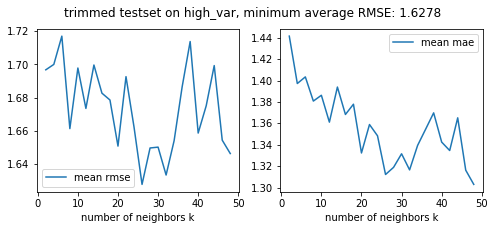

In [11]:
%%time
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
#rmse,mae=algo_cv(model,ratings,k_list,trim=None)
#rmse_pop,mae_pop=algo_cv(model,ratings,k_list,trim='popular')
#rmse_unpop,mae_unpop=algo_cv(model,ratings,k_list,trim='unpopular')
rmse_high_var,mae_hig_var=algo_cv(model,ratings,k_list,trim='high_var')

In [8]:
print('Q18, min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse),k_list[np.argmin(rmse)],np.min(mae),k_list[np.argmin(mae)]),
      '\nAccording to readme file there are 18 movie genres')

Q18, min rmse is 0.9144 at k=16 latent factors, min mae is 0.6941 at k=24 latent factors. 
According to readme file there are 18 movie genres


### Q22 Plot the ROC curves for the NNMF-based collaborative filter

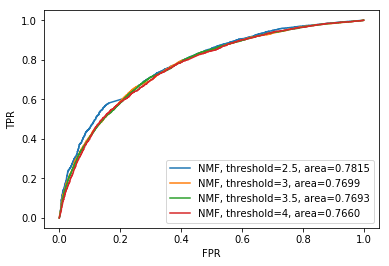

In [9]:
algo = NMF(k_list[np.argmin(rmse)])
plot_roc_curve(algo,ratings,'NMF')

### Question 23: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?
In question 23, there will be 20 columns of V and you don’t need to report the top 10 movies and genres for all the 20 columns. You will get full credit, as long as you report for a couple columns and provide a clear explanation on the connection between movie genres and latent factors.

In [47]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader).build_full_trainset()
algo=NMF(20)
algo.fit(data)
item_factor=algo.qi
movie_orders=np.argsort(item_factor,axis=0)
top_movies=pd.DataFrame(movie_orders[-1:-11:-1 , :])
movies=pd.read_csv('ml-latest-small/movies.csv')
genres=top_movies.applymap(lambda x: movies.iloc[x]['genres'])
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Drama,Action|Comedy,Action|Adventure|Fantasy|Sci-Fi,Drama,Action|Adventure|Fantasy,Comedy,Action|Comedy|Fantasy|Horror,Drama,Comedy,Comedy,Drama,Crime|Drama|Mystery|Thriller,Drama|Horror|Mystery|Thriller,Comedy|Romance,Comedy|Horror|Sci-Fi,Drama,Comedy|Crime|Thriller,Drama,Crime|Drama,Drama
1,Drama|Horror|Romance|Thriller,Comedy|Drama,Drama|Romance|War,Action|Crime|Horror,Drama,Drama|Fantasy|Romance,Drama,Action|Comedy|Drama|Thriller,Horror,Fantasy|Mystery|Thriller,Comedy,Drama|Thriller,Drama|War,Crime|Drama|Thriller,Adventure|Drama,Drama|Musical,Drama|Thriller|War,Drama,Comedy,Horror
2,Crime|Mystery|Thriller,Comedy|Horror|Sci-Fi,Drama,Comedy|Musical|Romance,Action|Drama|Thriller,Film-Noir|Thriller,Horror|Mystery|Sci-Fi,Adventure|Comedy|Fantasy,Comedy|Drama|Romance,Action|Adventure|Fantasy|Sci-Fi,Adventure|Animation|Children|Comedy,Action|Mystery|Thriller,Action|Sci-Fi,Drama|Western,Crime|Drama,Drama,Drama|Romance,Comedy|Drama|Romance,Crime|Drama,Action|Adventure|Drama
3,Drama,Action|Adventure|Comedy|Fantasy,Drama|Romance,Documentary,Adventure|Children,Horror|Thriller,Drama|Thriller,Action|Drama|Thriller,Documentary,Mystery|Thriller,Drama|Horror|Mystery|Romance|Thriller,Comedy|Crime|Mystery,Comedy|Romance,Horror|Mystery|Thriller,Drama,Drama|Film-Noir,Action|Comedy,Comedy,Horror|Thriller,Horror
4,Romance|Sci-Fi,Drama,Drama|Fantasy|Horror|Romance,Comedy|Drama,Comedy|Romance,Action|Crime|Drama|Thriller,Comedy,Drama,Drama|Romance,Adventure|Comedy|Fantasy,Action|Adventure|Fantasy|Mystery,Drama|Thriller,Children|Comedy,Drama,Crime|Drama|Thriller,Comedy|Drama,Drama,Action|Adventure|Fantasy,Comedy|Romance,Drama
5,Horror|Thriller,Drama,Comedy,Comedy|Romance,Comedy,Crime|Drama,Action|Adventure|Animation|Children|Comedy|IMAX,Drama|Romance,Crime|Mystery|Thriller,Comedy|Drama|Romance,Drama|Romance,Drama,Comedy|Drama,Comedy|Drama|Fantasy|Romance,Action|Drama,Drama,Horror|Sci-Fi,Adventure|Comedy|Sci-Fi,Drama|Thriller,Drama
6,Drama|Thriller|War,Comedy|Drama|Romance,Action|Adventure|Drama|Romance,Action|Animation|Film-Noir|Sci-Fi|Thriller,Crime,Crime|Drama,Animation|Fantasy|Mystery,Action|Comedy|Sci-Fi|IMAX,Adventure|Animation|Children|Fantasy,Comedy,Drama,Drama,Crime|Thriller,Comedy|Drama,Comedy|Musical|Romance,Horror|Sci-Fi,Drama|Thriller,Horror,Comedy,Action|Horror|Mystery|Sci-Fi
7,Adventure|Drama|Western,Animation|Drama,Horror|Sci-Fi,Action|Comedy|Crime|Thriller,Drama,Children|Comedy,Action|Adventure|Drama|War,Drama|Mystery,Comedy,Adventure|Drama|Sci-Fi,Crime|Horror|Thriller,Adventure|Children|Comedy|Mystery,Comedy|War,Animation|Documentary,Action|Thriller,Comedy|Romance,Drama|Romance,Comedy|Drama,Drama,Documentary
8,Action|Crime|Drama,Documentary|Drama,Comedy|Romance,Action|Drama|War,Drama|Romance,Drama,Action|Adventure|Sci-Fi,Action|Horror|Sci-Fi,Horror|Sci-Fi|Thriller,Crime|Drama,Drama|Film-Noir|Mystery,Action|Adventure|Fantasy|Mystery,Adventure|Drama|Sci-Fi,Comedy,Film-Noir|Mystery|Thriller,Comedy,Drama|Musical|Romance,Drama,Crime|Drama|Thriller,Animation|Fantasy
9,Adventure|Children|Comedy|Mystery,Adventure|Western,Crime|Drama|Romance|Thriller,Documentary,Action|Drama|Thriller,Adventure|Fantasy,Drama,Action|Adventure|Thriller,Adventure|Animation|Children|Drama|Musical,Adventure|Crime|Drama,Drama,Crime|Drama,Action|Comedy|Sci-Fi,Drama,Drama|Romance,Drama|Mystery|Thriller,Drama|Romance,Comedy|Romance,Comedy|Crime|Romance,Drama


### Q24, 26-28

CPU times: user 36min 16s, sys: 29.1 s, total: 36min 45s
Wall time: 41min 28s


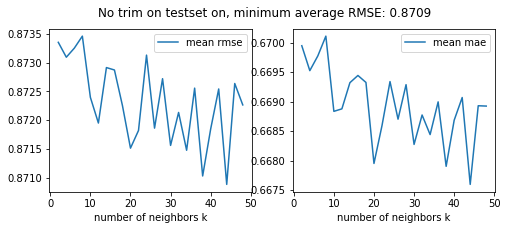

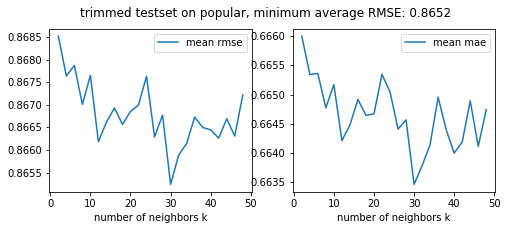

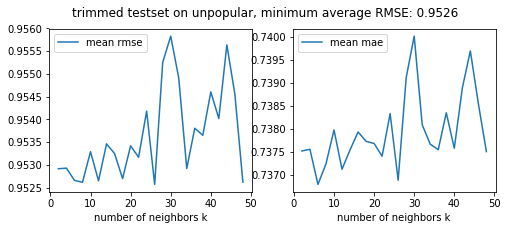

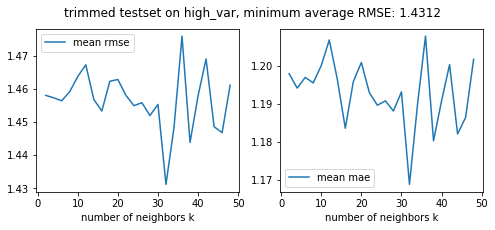

In [16]:
%%time
from surprise.prediction_algorithms.matrix_factorization import SVD
model=SVD #only takes int, not np.int
k_list=list(range(2,50,2))
rmse,mae=algo_cv(model,ratings,k_list,trim=None)
rmse_pop,mae_pop=algo_cv(model,ratings,k_list,trim='popular')
rmse_unpop,mae_unpop=algo_cv(model,ratings,k_list,trim='unpopular')
rmse_high_var,mae_hig_var=algo_cv(model,ratings,k_list,trim='high_var')

In [14]:
print('Q25, min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse),k_list[np.argmin(rmse)],np.min(mae),k_list[np.argmin(mae)]),
      '\nAccording to readme file there are 18 movie genres')

Q25, min rmse is 0.8715 at k=26 latent factors, min mae is 0.6679 at k=38 latent factors. 
According to readme file there are 18 movie genres


### Q29 Plot the ROC curves for the MF with bias (SVD) collaborative filter

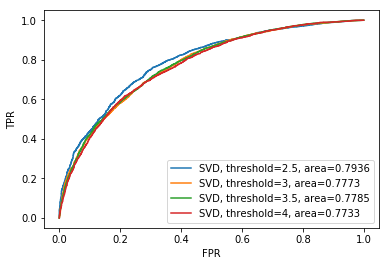

In [15]:
algo = SVD(k_list[np.argmin(rmse)])
plot_roc_curve(algo,ratings,'SVD')

### Q30-33 Naive collaborative filtering

In [74]:
""" Train on the whole dataset, only predict on different trimmed testsets """
est=pd.DataFrame(ratings.groupby('userId')['rating'].transform(np.mean)).rename(columns={'rating':'est'})
naive_filtered=pd.concat([ratings,est],axis=1)

popular_movies = ratings.groupby('movieId').filter(lambda x: x['rating'].count()>2)['movieId'].unique()
unpopular_movies = ratings.groupby('movieId').filter(lambda x: x['rating'].count()<=2)['movieId'].unique()
high_var_movies=ratings.groupby('movieId').filter(lambda x: (x['rating'].count()>=5) 
                                                          & (x['rating'].var(ddof=0)>=2))['movieId'].unique()
def naive_col_filt(naive_filtered,trim=None):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_folds=[]
    for train_index, test_index in kf.split(naive_filtered):
        X_test=naive_filtered.iloc[test_index]
        if trim=='popular': X_test=X_test[X_test['movieId'].isin(popular_movies)]
        elif trim=='unpopular': X_test=X_test[X_test['movieId'].isin(unpopular_movies)]
        elif trim=='high_var': X_test=X_test[X_test['movieId'].isin(high_var_movies)]
        rmse_folds.append((np.mean((X_test['rating']-X_test['est'])**2))**0.5)
    print('Naive collaborative filtering on 10-folds',trim,
          'trimmed testsets average RMSE: {:.4f}'.format(np.mean(rmse_folds)))
    
naive_col_filt(naive_filtered)
naive_col_filt(naive_filtered, trim='popular')
naive_col_filt(naive_filtered, trim='unpopular')
naive_col_filt(naive_filtered, trim='high_var')

Naive collaborative filtering on 10-folds None trimmed testsets average RMSE: 0.9347
Naive collaborative filtering on 10-folds popular trimmed testsets average RMSE: 0.9323
Naive collaborative filtering on 10-folds unpopular trimmed testsets average RMSE: 0.9711
Naive collaborative filtering on 10-folds high_var trimmed testsets average RMSE: 1.4536


### Q34 Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

In [79]:
def compare_with_ROC(algos,labels):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=.1)
    for i,algo in enumerate(algos):
        algo.fit(trainset)
        predictions = algo.test(testset)
        scores=[pred.est for pred in predictions]
        rui_list=[pred.r_ui for pred in predictions]
        t=3
        y=[int(rui>t) for rui in rui_list]
        fpr, tpr, _= metrics.roc_curve(y, scores, pos_label=1)
        auc=metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,label=labels[i]+', area={:.4f}'.format(auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

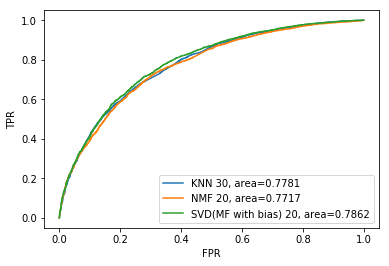

In [82]:
algos=[KNNWithMeans(k=30, sim_options={'name': 'pearson','user_based': True},verbose=False),
      NMF(k_list[np.argmin(rmse)]),
      SVD(k_list[np.argmin(rmse)])]
labels=['KNN 30', 'NMF 20', 'SVD(MF with bias) 20']
compare_with_ROC(algos,labels)

### Q 35 Precision and Recall are defined by the mathematical expres- sions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words

Precision: the ratio of correctly predicted liked-movie out of all predicted liked-movies, similar to accuracy

Recall: the ratio of recovered liked-movie by prediction out of all groud truth liked-movies, similar to sensitivity

### Q 36-39 PR curves

In [43]:
def rank_movies(ratings,algo,label):
    reader = Reader(rating_scale=(0.5, 5))
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    precision,recall=[],[]
    for train_index, test_index in kf.split(ratings):
        train_df,test_df=ratings.iloc[train_index],ratings.iloc[test_index]
        trainset = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader).build_full_trainset()
        testset = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        algo.fit(trainset)
        predictions=pd.DataFrame([p.est for p in algo.test(testset)],columns=['est'])
        df_est=pd.concat([test_df[['userId','movieId']].reset_index(drop=True),predictions],axis=1)
        t_list=np.arange(1,26)
        precision_fold,recall_fold=[],[]
        for t in t_list:
            S=df_est.sort_values(by=['userId','est'],ascending=[True,False]).groupby('userId').head(t)
            """SG=join df_est with test_df, then drop rows with no ground truth rating"""
            SG=S.merge(test_df,how='outer',on=['userId','movieId'])
            SG=SG[SG['rating'].notna()]
            """count rows based on condition, """
            tp=SG[SG['est'].notna()&(SG['rating']>=3)].groupby('userId')['movieId'].count().\
                                                                                to_frame().rename(columns={'movieId':'tp'})
            fp=SG[SG['est'].notna()&(SG['rating']<3)].groupby('userId')['movieId'].count().\
                                                                                to_frame().rename(columns={'movieId':'fp'})
            fn=SG[SG['est'].isna()&(SG['rating']>=3)].groupby('userId')['movieId'].count().\
                                                                                to_frame().rename(columns={'movieId':'fn'})
            pr=tp.merge(fp,how='outer',on='userId').merge(fn,how='outer',on='userId').fillna(value=0)
            precision_fold.append((pr['tp']/(pr['tp']+pr['fp'])).mean())
            recall_fold.append((pr['tp']/(pr['tp']+pr['fn'])).mean())
        precision.append(precision_fold)
        recall.append(recall_fold)
    p=np.mean(precision,axis=0)
    r=np.mean(recall,axis=0)
        
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))
    ax1.plot(t_list,r,label=label+', recall')
    ax1.plot(t_list,p,label=label+' ,precision')
    ax1.legend()
    ax2.plot(r,p,label=label)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    return p,r

NameError: name 'NMF' is not defined

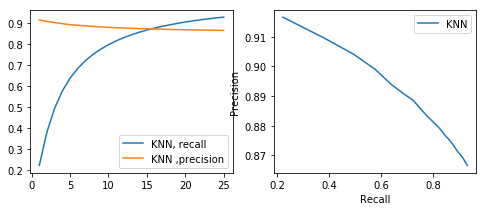

In [44]:
algo=KNNWithMeans(k=30, sim_options={'name': 'pearson','user_based': True},verbose=False)
p_knn,r_knn=rank_movies(ratings,algo,'KNN')

algo=NMF(16)
p_nmf,r_nmf=rank_movies(ratings,algo,'NMF')

algo=SVD(24)
p_mf,r_mf=rank_movies(ratings,algo,'MF(SVD)')

### Q39

In [ ]:
plt.plot(r_knn,p_knn,label='KNN')
plt.plot(r_nmf,p_nmf,label='NMF')
plt.plot(r_mf,p_mf,label='MF(SVD)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()